# 模型构建与模型优化
- CNN2d 网络构建
- dropout 缓解过拟和问题（模型优化1）
- batch normalization 数据批标准化(模型优化2)
- model.train and model.eval 训练和预测模式
- 缓解过拟合问题的方法之三
    - 增大训练集
    - dropout：起到平局的作用，减少神经元之间复杂的共适应能力。 该层只有在训练的时候起作用，在预测的时候不起作用。
    - batch normalization：正则化效果，提高模型的泛化能力，加快收敛速度，允许更深的模型，允许更大的学习速率

In [1]:
import os
# copy image
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms

import time
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from timm.loss import LabelSmoothingCrossEntropy
from thop import profile, clever_format
%matplotlib inline

from model import basic_cnn, resNet50, InceptionV3
from model import mobileNetV2, mobileNetV3, mobileNetV1
from metrics.metrics_v1 import metric_log

/root/miniconda3/envs/py12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- torchvision.datasets.ImageFolder
- 从分类文件夹中创建dataset
- 所以要创建文件夹，并把各种图片放进去

In [2]:
# specises = ['cloudy', 'rain', 'shine', 'sunrise']
specises = ['aphids', 'armyworm', 'beetle', 'bollworm', "grasshopper", "mites", "mosquito", "sawfly", "stem_borer"]

epoches = 100
BATCHSZ = 16

# model_name = "basicCnnNet1"
# model_name = "basicCnnNet2"
# model_name = 'mobileNetV2'
# model_name = 'mobileNetV3'
model_name = 'mobilenetv3_large'
model_name = 'mobilenetv3_small'
# model_name = 'mobileNetV1'
# model_name = 'resNet50'
# model_name = 'InceptionV3'
path_head = '/home/leo/Classification/04CNN'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# result_dir = "/home/leo/Classification/04CNN/results/0822-221014-InceptionV3"
# result_dir = "/home/leo/Classification/04CNN/results/0822-234330-resNet50"
result_dir = "/home/leo/Classification/04CNN/results/0823-093508-mobileNetV1"
result_dir = "/home/leo/Classification/04CNN/results/0823-095412-mobileNetV2"
result_dir = "/home/leo/Classification/04CNN/results/0823-101520-mobilenetv3_small"
# result_dir = "/home/leo/Classification/04CNN/results/0823-105305-mobilenetv3_large"

In [4]:
base_dir = "/home/leo/SMD/BAUInsectv2Pest"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

for train_or_test in ['train', 'test']:
    for spec in specises:
        print(train_or_test, spec, len(os.listdir(os.path.join(base_dir, train_or_test, spec))))

train aphids 266
train armyworm 223
train beetle 291
train bollworm 245
train grasshopper 277
train mites 254
train mosquito 295
train sawfly 200
train stem_borer 181
test aphids 44
test armyworm 43
test beetle 50
test bollworm 36
test grasshopper 46
test mites 42
test mosquito 50
test sawfly 37
test stem_borer 36


In [5]:
transform = transforms.Compose([
    # transforms.Resize((156, 156)),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),   # 三个作用，归一化，channel first， tensor
    # RGB 三个维度
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # 这里的均值方差是猜的，知道的情况可以用正确的
])

In [6]:
# train
train_ds = torchvision.datasets.ImageFolder(
                                train_dir, transform=transform)
test_ds = torchvision.datasets.ImageFolder(
                                test_dir, transform=transform)

In [7]:
# 查看类别 
# 查看编号 
print(train_ds.classes, train_ds.class_to_idx)

# 长度
print(len(train_ds), len(test_ds))

# 返回可遍历的(键, 值) 元组数组
print(train_ds.class_to_idx.keys())
# train_ds.class_to_idx

['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer'] {'aphids': 0, 'armyworm': 1, 'beetle': 2, 'bollworm': 3, 'grasshopper': 4, 'mites': 5, 'mosquito': 6, 'sawfly': 7, 'stem_borer': 8}
2232 384
dict_keys(['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer'])


In [8]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCHSZ, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCHSZ)

In [9]:
# # 拿出来一个批次的数据
imgs, labels = next(iter(train_dl))

# # 因为已经用torch的dataset，所以需要改变维度顺序
# # permute 交换channel的顺序，的应用对象是 torch的tensor
# print(imgs[0].shape)
# img = (imgs[0].permute(1, 2, 0).numpy() + 1) / 2
# print(img.shape, img.max(), type(img))

# print("labels", labels)

# # plt.figure(figsize=(12, 8))
# plt.title(labels[0].numpy())
# plt.imshow(img)

In [10]:
# 交换键和值的位置,用于获取值写 title
# 可能这种写法比较简单吧，我没有试验直接获得字符串标签的写法
id_to_class = dict((v, k) for k, v in train_ds.class_to_idx.items())
id_to_class

{0: 'aphids',
 1: 'armyworm',
 2: 'beetle',
 3: 'bollworm',
 4: 'grasshopper',
 5: 'mites',
 6: 'mosquito',
 7: 'sawfly',
 8: 'stem_borer'}

In [11]:
# plt.figure(figsize=(12, 8))
# for i, (img, label) in enumerate(zip(imgs[:6], labels[:6])):
#     img = (img.permute(1, 2, 0).numpy() + 1) / 2
#     plt.subplot(2, 3, i+1)
#     plt.title(id_to_class.get(label.item()))
#     plt.imshow(img)

# Model

In [12]:
if model_name == "basicCnnNet1":
    model = basic_cnn.Net1(classes=torch.max(labels).item()+1).to(device)
elif model_name == "basicCnnNet2":
    model = basic_cnn.Net2(classes=torch.max(labels).item()+1).to(device)
elif model_name =="mobileNetV2":
    model = mobileNetV2.mobilenet_v2(pretrained=False).to(device)
elif model_name =="mobilenetv3_large":
    model = mobileNetV3.mobilenetv3_large().to(device)
elif model_name =="mobilenetv3_small":
    model = mobileNetV3.mobilenetv3_small().to(device)
elif model_name =="mobileNetV1":
    model = mobileNetV1.MyMobileNet_v1(num_classes=9).to(device)
elif model_name =="resNet50":
    # model = InceptionV3.MyInception_v3(num_classes=9).to(device)
    model = resNet50.resnet50(num_classes=9).to(device)
elif model_name =="InceptionV3":
    # model = InceptionV3.MyInception_v3(num_classes=9).to(device)
    model = InceptionV3.GoogLeNetV3(num_classes=9).to(device)
print(model_name)

mobilenetv3_small


In [13]:
# # FLOPs and Params
# flops, params = profile(model, 
#             inputs=(torch.randn(2, 3, 256, 256).to(device),))

# # flops, params = profile(model, inputs=(torch.randn(2, hsi_bands).to(args.device),  torch.randn(2, sar_bands).to(args.device)))

# flops, params = clever_format([flops, params])
# print('# Model FLOPs: {}'.format(flops))
# print('# Model Params: {}'.format(params))

In [14]:
# smoothing = 0.1
# if model_name == 'InceptionV3':
#     loss_fn = InceptionV3.Loss_Inception_v3(9, smoothing)
#     # loss_fn = LabelSmoothingCrossEntropy(smoothing)
# else:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
print(model_name)

mobilenetv3_small


# Test

In [15]:
path = os.path.join(result_dir, 'theCurve.pth')
if path != '':
    checkpoint = torch.load(path)
    epoch_start = checkpoint['epoch'] + 1
    train_loss  = checkpoint['train_loss']
    train_acc = checkpoint['train_acc']
    test_loss = checkpoint['test_loss']
    test_acc =  checkpoint['test_acc']
    print('Loaded from: {}'.format(path), "start", epoch_start)

Loaded from: /home/leo/Classification/04CNN/results/0823-101520-mobilenetv3_small/theCurve.pth start 100


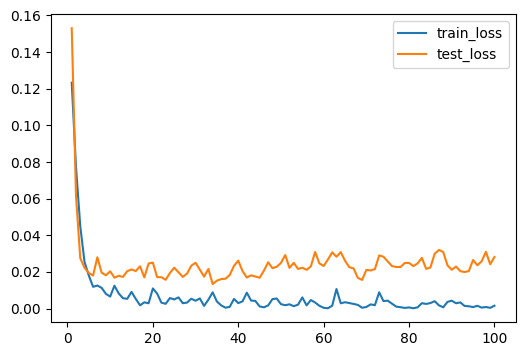

In [16]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, epoch_start+1), train_loss, label="train_loss")
plt.plot(range(1, epoch_start+1), test_loss, label="test_loss")
plt.legend()

plt.savefig(os.path.join(result_dir, 'loss.png'), dpi=300)

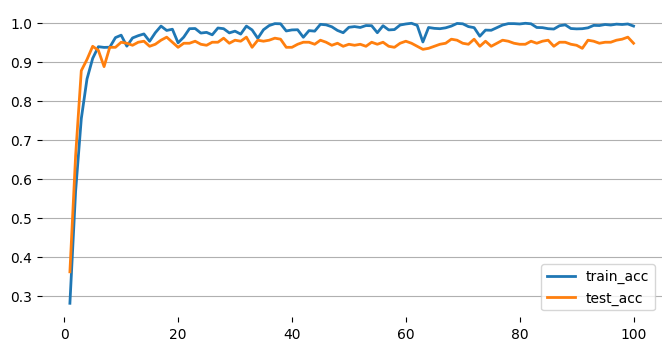

In [17]:
plt.figure(figsize=(8, 4))


ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.grid(axis='y')  

plt.plot(range(1, epoch_start+1), train_acc, label="train_acc", linewidth=2)
plt.plot(range(1, epoch_start+1), test_acc, label="test_acc", linewidth=2)

plt.legend()
plt.savefig(os.path.join(result_dir, 'acc.png'), dpi=300)

In [18]:
path = os.path.join(result_dir, 'weights.pth')
if path != '':
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model'], strict=False)
    epoch_start = checkpoint['epoch'] + 1
    print('Loaded from: {}'.format(path), "start", epoch_start)

Loaded from: /home/leo/Classification/04CNN/results/0823-101520-mobilenetv3_small/weights.pth start 101


In [19]:
def test(model, testloader):

    test_correct = 0
    test_total = 0
    test_running_loss = 0
    test_pred_list = []
    test_label_list = []

    # 预测模式影响 dropout Batch, Normalization
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
                
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()

            test_label_list.extend(y.cpu().numpy())
            test_pred_list.extend(y_pred.cpu().numpy())

    test_loss = test_running_loss / len(testloader.dataset)
    test_accuracy = test_correct / test_total

    print('test_loss: ', round(test_loss, 3),
        'test_accuracy', round(test_accuracy, 3))

    return test_loss, test_accuracy, test_pred_list, test_label_list

In [20]:
starttime = time.time()
test_loss, test_acc, test_preds, test_labels = test(model, test_dl)
test_time = time.time() - starttime

test_loss:  0.028 test_accuracy 0.948


In [21]:
matrix, classification, accuracy, precision, recall, f1, kappa = \
                            metric_log(test_preds, test_labels)
f = open(os.path.join(result_dir, 'results2.txt'), 'a+')
str_results = '\n ======================' \
            + '\n' + classification \
            + "\nmatrix = \t\t" + str(matrix) \
            + "\nepoch_start = \t" + str(epoch_start) \
            + "\naccuracy = \t\t" + str(round(accuracy, 4)) \
            + "\nprecision = \t" + str(round(precision, 4)) \
            + "\nrecall = \t\t" + str(round(recall, 4)) \
            + "\nf1 = \t\t\t\t" + str(round(f1, 4)) \
            + "\nkappa = \t\t\t" + str(round(kappa, 4)) \
            + '\ntest time = \t' + str(round(test_time, 2)) \
            + '\n'
f.write(str_results)
f.close()

accuracy 0.9479166666666666
precision 0.9459606429171648
recall 0.9449465783372086
f1 0.9452311101014819
kappa 0.9412906875410889
